<a href="https://colab.research.google.com/github/mtermor/NTIC_DeepLearning/blob/main/NLP/tarea2_nlp_MTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering Fine-tuning

La siguiente tarea consiste en entrenar un modelo de HuggingFace (HF) para realizar la _task_ de _question_answering_. El dataset para entrenar dicho modelo está predefinido. Sin embargo, el modelo, el tokenizador y el trainer pueden ser totalmente personalizados. Es decir, que tendréis que realizar un trabajo de investigación, de prueba y error, para poder ir aprendiendo y ganando destreza con HF.

Recomendaciones:
- Durante este proceso, tendréis muchas dudas y encontraréis muchos errores. Tratad de resolverlas primero por vuestra cuenta, enteniendo la causa del error. Después con recursos online. Y, finalmente, siempre está el foro, que puede ser utilizado de forma participativa.
- No dejeis la tarea para el último día. Los modelos tardan en entrenar. Los problemas no se resuelven en la primera iteración.

Finalmente, se pide:
- Limpieza rigurosa en la presentación del notebook.
- El notebook se entrega con todas las celdas ejecutadas.
- Los comentarios (opcionales), mejor sobre el código con '#'.

Ánimo!

## Dataset

A continuación, descargarás un dataset llamado _squad_ que contiene 87599 filas en el dataset de train y 10570 registros en el dataset de validation.

Lo primero que tendrás que hacer es construir un dataset nuevo, llamado **ds_tarea**, que filtre el anterior dataset para quedarse con los registros que tengan el contenido de la columna _context_  con menos (estrictamente) de 300 caracteres.

In [1]:
#!pip install datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("squad")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [3]:
# Filtrar registros con 'context' menores de 300 caracteres
ds_tarea = dataset.filter(lambda example: len(example['context']) < 300)

ds_tarea

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 3466
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 345
    })
})

In [4]:
assert len(ds_tarea['train']) == 3466
assert len(ds_tarea['validation']) == 345

## EDA

Si tenéis que realizar alguna exploración del datos, utilizad esta sección.

In [5]:
# Celdas de libre uso

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
## RESUMEN DESCRIPTIVO
# Recuento de registros en cada conjunto de datos
for split in ds_tarea.keys():
    print(f"{split} tiene {ds_tarea[split].num_rows} registros")

# Tipos de datos y características de cada columna
for split in ds_tarea.keys():
    print(f"\nCaracterísticas del conjunto de datos {split}:")
    print(ds_tarea[split].features)

train tiene 3466 registros
validation tiene 345 registros

Características del conjunto de datos train:
{'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

Características del conjunto de datos validation:
{'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}


In [8]:
## VISUALIZAR EJEMPLOS DE DATOS
print("Ejemplo de entrenamiento:")
print(ds_tarea['train'][0])

print("\nEjemplo de validación:")
print(ds_tarea['validation'][0])

Ejemplo de entrenamiento:
{'id': '56bea27b3aeaaa14008c9199', 'title': 'Beyoncé', 'context': 'On February 6, 2016, one day before her performance at the Super Bowl, Beyoncé released a new single exclusively on music streaming service Tidal called "Formation".', 'question': 'Beyonce released the song "Formation" on which online music service?', 'answers': {'text': ['Tidal'], 'answer_start': [140]}}

Ejemplo de validación:
{'id': '56be53b8acb8001400a50314', 'title': 'Super_Bowl_50', 'context': 'In early 2012, NFL Commissioner Roger Goodell stated that the league planned to make the 50th Super Bowl "spectacular" and that it would be "an important game for us as a league".', 'question': 'Who was the NFL Commissioner in early 2012?', 'answers': {'text': ['Roger Goodell', 'Roger Goodell', 'Goodell'], 'answer_start': [32, 32, 38]}}


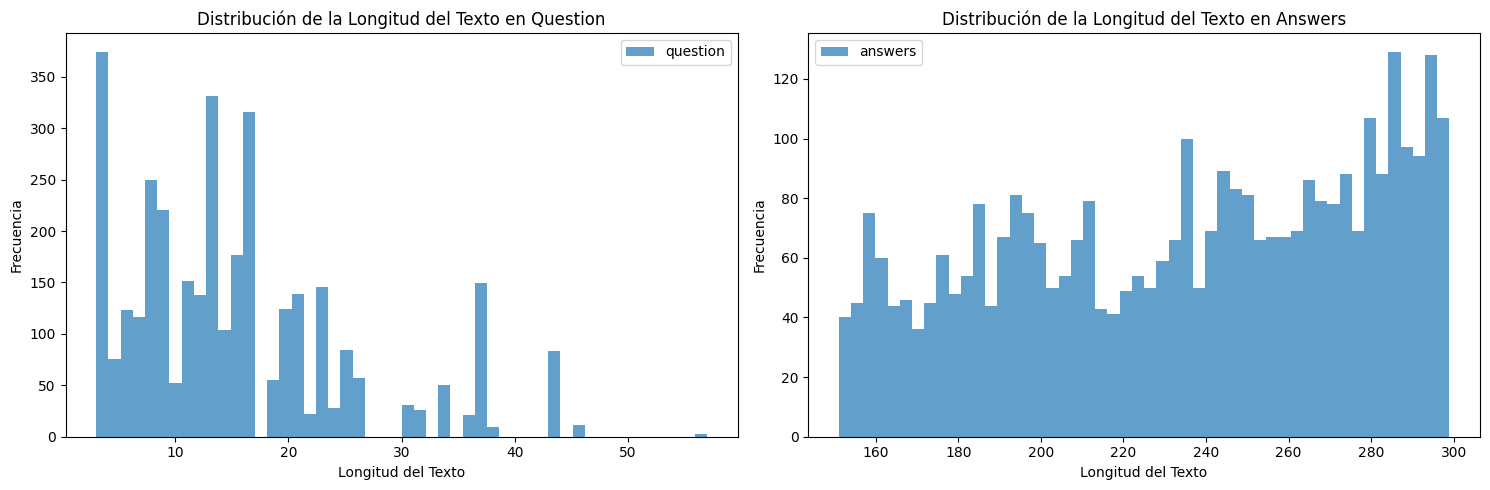

In [9]:
## DISTRIBUCIÓN DE LA LONGITUD DEL TEXTO
# Análisis de la longitud de los textos en question y answers con histogramas
question_lengths = [len(text) for text in ds_tarea['train']['title']]
answers_lengths = [len(text) for text in ds_tarea['train']['context']]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(question_lengths, bins=50, alpha=0.7, label='question')
axs[0].set_xlabel('Longitud del Texto')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Distribución de la Longitud del Texto en Question')
axs[0].legend()

axs[1].hist(answers_lengths, bins=50, alpha=0.7, label='answers')
axs[1].set_xlabel('Longitud del Texto')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Distribución de la Longitud del Texto en Answers')
axs[1].legend()

plt.tight_layout()
plt.show()

## Feature Engineering

Si tenéis que realizar alguna modificación de los datos (no siempre es necesaria, pero algunos modelos preentrenados lo piden), podéis utilizar esta sección.

Al finalizar la sección, bien si modificais el dataset, bien si no lo modificáis, lo guardaréis en un dataset llamado __ds_tarea_featured__.

In [10]:
# Celdas de libre uso

In [11]:
from transformers import BertTokenizer

# Tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para tokenizar contextos y preguntas
def tokenize_examples(example):
    tokenized_example = tokenizer(
        example['question'],
        example['context'],
        truncation='only_second',  # Solo truncar el contexto si excede el límite de tokens
        max_length=512,            # Longitud máxima permitida para BERT
        padding='max_length',      # Rellenar hasta la longitud máxima
        return_tensors='pt'        # Devolver tensores de PyTorch
    )
    return tokenized_example
    # Tokenizar las preguntas y contextos
    tokenized_examples = tokenizer(
        examples["question"], examples["context"],
        truncation="only_second", max_length=384,
        stride=128, return_overflowing_tokens=True,
        return_offsets_mapping=True, padding="max_length"
    )
# Tokenizar todos los ejemplos en ds_tarea
ds_tarea_featured = ds_tarea.map(tokenize_examples, batched=True)

In [12]:
assert len(ds_tarea_featured['train']) == 3466
assert len(ds_tarea_featured['validation']) == 345

## Model and Tokenizer

El modelo finalmente escogido para hacer el fine-tuning, declaradlo en la variable _model_checkpoint_. Con dicho modelo seleccionado, se pide guardar el modelo y el tokenizador en las variables _model_ y _tokenizer_.

In [13]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering

# Nombre del checkpoint del modelo a utilizar
model_checkpoint = "distilbert-base-uncased"

# Inicializar el tokenizador y el modelo para question answering
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
model = DistilBertForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tuning

A continuación, de forma libre se pide entrenar un modelo de HuggingFace deseado. Se pide usar un Trainer de HuggingFace que tenga los siguientes argumentos como mínimo (puede haber más argumentos en todas las variables):

In [14]:
#!pip install transformers[torch]

In [15]:
from transformers import TrainingArguments, Trainer

import torch

args = TrainingArguments(
    output_dir='./results',  # Directorio de salida para guardar el modelo entrenado
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=1000,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tarea_featured["train"],
    eval_dataset=ds_tarea_featured["validation"],
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


A continuación se entrena el modelo

In [16]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: start_logits,end_logits. For reference, the inputs it received are input_ids,attention_mask.

In [17]:
# COMENTARIO: No he conseguido entrenar el modelo. La función "loss" no se
# calcula, y aunque la he intentado definir explicitamente, no consigo que se
# entrene correctamente.
# Como alternativa, he probado otros modelos con los que si he conseguido
# entrenar el modelo, pero no hacer inferencia. Este modelo alternativo lo he
# añadido al final del notebook.

In [18]:
# trainer.save_model("xxx") Este código por si queréis salvarlo

## Evaluation

En este apartado, no vamos a entrar esta vez métrics. Lo que se va a pedir, es tomar dos ejemplos del dataset de evaluación.

Con ambos ejemplos, vamos a ver cómo responden a las preguntas.

In [19]:
sample1 = 55
sample2 = 159

In [20]:
context1 = ds_tarea['validation'][sample1]['context']
question1 = ds_tarea['validation'][sample1]['question']
answer1 = ds_tarea['validation'][sample1]['answers']

ds_tarea['validation'][sample1]

{'id': '56bec0353aeaaa14008c934f',
 'title': 'Super_Bowl_50',
 'context': 'In addition to the Vince Lombardi Trophy that all Super Bowl champions receive, the winner of Super Bowl 50 will also receive a large, 18-karat gold-plated "50". Each digit will weigh 33 lb (15 kg) for a total of 66 lb (30 kg). Like the Lombardi Trophy, the "50" will be designed by Tiffany & Co.',
 'question': 'What will the "50" given to the Super Bowl winner weigh in pounds?',
 'answers': {'text': ['66', '66 lb', '33'], 'answer_start': [213, 213, 184]}}

In [21]:
context2 = ds_tarea['validation'][sample2]['context']
question2 = ds_tarea['validation'][sample2]['question']
answer2 = ds_tarea['validation'][sample2]['answers']

ds_tarea['validation'][sample2]

{'id': '56e11c24e3433e1400422c18',
 'title': 'Nikola_Tesla',
 'context': 'Tesla was 6 feet 2 inches (1.88 m) tall and weighed 142 pounds (64 kg), with almost no weight variance from 1888 to about 1926.:292 He was an elegant, stylish figure in New York City, meticulous in his grooming, clothing, and regimented in his daily activities.',
 'question': 'How much did Tesla weigh?',
 'answers': {'text': ['142 pounds', '142 pounds', '142 pounds (64 kg)'],
  'answer_start': [52, 52, 52]}}

Aquí se pide hacer la inferencia del modelo entrenado y poner los resultados en las variables _response1_ y _response2_.

In [22]:
# Para cada ejemplo seleccionado (sample1 y sample2), proporcionamos la pregunta
# (question) y el contexto (context) al pipeline. El pipeline devuelve un
# diccionario que contiene la respuesta más probable (answer).
from transformers import pipeline

qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer)

response1 = None
response2 = None

In [23]:
# Inferencia para el primer ejemplo
result1 = qa_pipeline({
    'question': question1,
    'context': context1
})
response1 = result1['answer']

print('Question: ', question1)
print('Generated response: ', response1)
print('Original answer: ', answer1)

Question:  What will the "50" given to the Super Bowl winner weigh in pounds?
Generated response:  In addition to the Vince Lombardi
Original answer:  {'text': ['66', '66 lb', '33'], 'answer_start': [213, 213, 184]}


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [24]:
# Inferencia para el segundo ejemplo
result2 = qa_pipeline({
    'question': question2,
    'context': context2
})
response2 = result2['answer']
response2

print('Question: ', question2)
print('Generated response: ', response2)
print('Original answer: ', answer2)

Question:  How much did Tesla weigh?
Generated response:  (1.88 m) tall and weighed 142 pounds (64
Original answer:  {'text': ['142 pounds', '142 pounds', '142 pounds (64 kg)'], 'answer_start': [52, 52, 52]}


# Modelo alternativo propuesto

In [25]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

# Cargar el dataset SQuAD
dataset = load_dataset("squad")

# Filtrar registros con 'context' menores de 300 caracteres
ds_tarea = dataset.filter(lambda example: len(example['context']) < 300)

# Inicializar el tokenizador y el modelo T5
model_checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

# Función para preparar los datos para T5
def preprocess_function(examples):
    inputs = ["question: " + q + " context: " + c for q, c in zip(examples["question"], examples["context"])]
    targets = [a["text"][0] for a in examples["answers"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Aplicar la función a todos los ejemplos en ds_tarea
ds_tarea = ds_tarea.map(preprocess_function, batched=True)

# Definir los argumentos de entrenamiento
args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=100,  # Log every 100 steps for more frequent logging
    save_steps=1000,
    evaluation_strategy="epoch",
    logging_strategy="steps"  # Ensure logging by steps
)

# Inicializar el entrenador
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tarea["train"],
    eval_dataset=ds_tarea["validation"],
    tokenizer=tokenizer
)

# Entrenar el modelo
trainer.train()


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/3466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/345 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.132100,0.036657
2,0.030600,0.020366
3,0.023100,0.019962


TrainOutput(global_step=651, training_loss=0.7020175682234874, metrics={'train_runtime': 457.5047, 'train_samples_per_second': 22.728, 'train_steps_per_second': 1.423, 'total_flos': 1407284051705856.0, 'train_loss': 0.7020175682234874, 'epoch': 3.0})

In [26]:
## CARGAR DATOS
from datasets import load_dataset

dataset = load_dataset("squad")
dataset

# Filtrar registros con 'context' menores de 300 caracteres
ds_tarea = dataset.filter(lambda example: len(example['context']) < 300)

ds_tarea

## FEATURE ENGINEERING
from transformers import BertTokenizer

# Tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para tokenizar contextos y preguntas
def tokenize_examples(example):
    tokenized_example = tokenizer(
        example['question'],
        example['context'],
        truncation='only_second',  # Solo truncar el contexto si excede el límite de tokens
        max_length=512,            # Longitud máxima permitida para BERT
        padding='max_length',      # Rellenar hasta la longitud máxima
        return_tensors='pt'        # Devolver tensores de PyTorch
    )
    return tokenized_example
    # Tokenizar las preguntas y contextos
    tokenized_examples = tokenizer(
        examples["question"], examples["context"],
        truncation="only_second", max_length=384,
        stride=128, return_overflowing_tokens=True,
        return_offsets_mapping=True, padding="max_length"
    )
# Tokenizar todos los ejemplos en ds_tarea
ds_tarea_featured = ds_tarea.map(tokenize_examples, batched=True)

## MODEL AND TOKENIZER
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering

# Nombre del checkpoint del modelo a utilizar
model_checkpoint = "distilbert-base-uncased"

# Inicializar el tokenizador y el modelo para question answering
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
model = DistilBertForQuestionAnswering.from_pretrained(model_checkpoint)

## FINE TUNING
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='./results',  # Directorio de salida para guardar el modelo entrenado
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=1000,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tarea_featured["train"],
    eval_dataset=ds_tarea_featured["validation"],
    tokenizer=tokenizer,
)

# Entrenar el modelo
trainer.train()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: The model did not return a loss from the inputs, only the following keys: start_logits,end_logits. For reference, the inputs it received are input_ids,attention_mask.